# UofT-DSI | Production - Assignment 2
Completed by: Yi-Chen Hsiao

# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [2]:
# Load the libraries as required.

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import shap
import pickle

In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [5]:
X = fires_dt.drop('area', axis = 1)
X.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


In [6]:
y = fires_dt['area']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [7]:
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']

preproc1 = ColumnTransformer([
        ('scaling', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
        remainder= 'passthrough')

preproc1

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

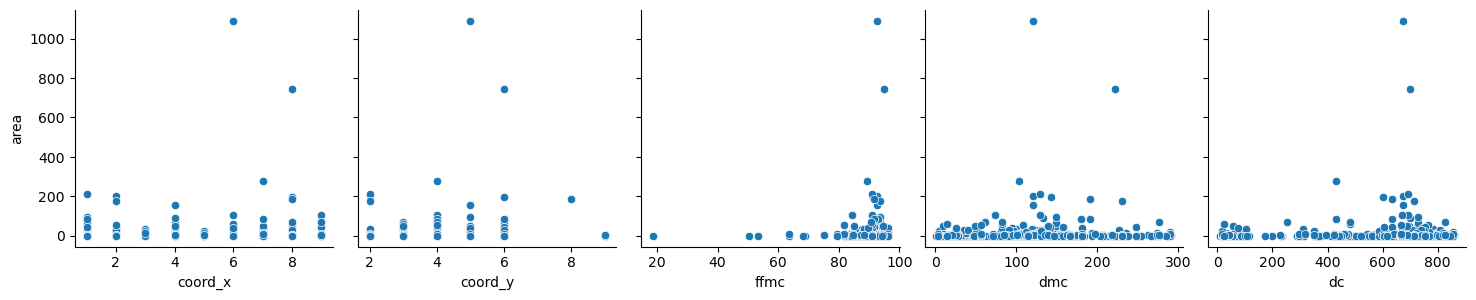

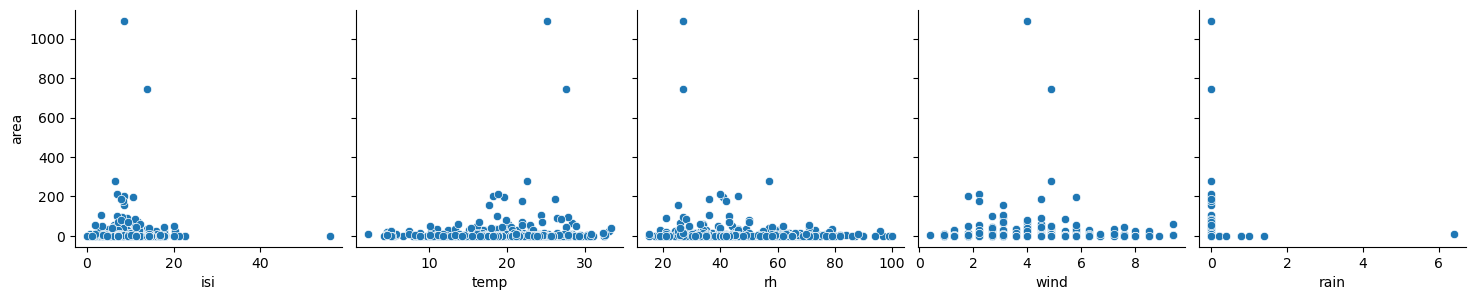

In [8]:
# Use pairplot to visualize the relationships between variables
sns.pairplot(fires_dt,x_vars = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc'], y_vars='area', height=3)
sns.pairplot(fires_dt,x_vars =  ['isi', 'temp', 'rh', 'wind', 'rain'], y_vars='area', height=3)

> The pairplots revealed potential non-linear relationships between:
> - `ffmc` and `area`
> - `rain` and `area`
> 
> Hence, I will perform non-liner transformation for `ffmc` and `rain`.

In [9]:
num_cols_2 = ['coord_x', 'coord_y', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind']
cat_cols = ['month', 'day']
trans_cols = ['ffmc', 'rain']

preproc2 = ColumnTransformer([
        ('scaling', StandardScaler(), num_cols_2),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('transform', PowerTransformer(method='yeo-johnson'), trans_cols)],
        remainder= 'passthrough')

preproc2

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', StandardScaler(),
                                 ['coord_x', 'coord_y', 'dmc', 'dc', 'isi',
                                  'temp', 'rh', 'wind']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day']),
                                ('transform', PowerTransformer(),
                                 ['ffmc', 'rain'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

**Pipeline A = preproc1 + baseline**

In [10]:
# Pipeline A = preproc1 + baseline

Pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', KNeighborsRegressor())
])

Pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [ ]:
# Define model evaluation metrics
scoring = ['r2',
    'neg_mean_squared_error', 
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error',
    'explained_variance']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Perform cross-validation for Pipeline A
result_A_dict = cross_validate(Pipeline_A , X_train, Y_train, cv = 5, scoring = scoring)
result_A = pd.DataFrame(result_A_dict).assign(experiment = 1)
result_A

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance,experiment
0,0.008263,2.547578,-0.221919,-1993.330721,-44.646732,-17.999157,-0.221305,1
1,0.011130,0.010562,-4.968430,-1291.160163,-35.932717,-17.034410,-4.632613,1
2,0.008085,0.013354,-0.626189,-1171.387382,-34.225537,-16.389687,-0.620724,1
3,0.007631,0.012907,-0.067271,-7689.458221,-87.689556,-23.816780,-0.055900,1
4,0.000000,0.020677,-0.099719,-645.651546,-25.409674,-11.789756,-0.073148,1


In [13]:
result_A.mean()

fit_time                               0.007022
score_time                             0.521015
test_r2                               -1.196706
test_neg_mean_squared_error        -2558.197607
test_neg_root_mean_squared_error     -45.580843
test_neg_mean_absolute_error         -17.405958
test_explained_variance               -1.120738
experiment                             1.000000
dtype: float64

**Pipeline B = preproc2 + baseline**

In [14]:
# Pipeline B = preproc2 + baseline

Pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', KNeighborsRegressor())
])

Pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'dmc',
                                                   'dc', 'isi', 'temp', 'rh',
                                                   'wind']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('transform',
                                                  PowerTransformer(),
                                                  ['ffmc', 'rain'])])),
                ('regressor', KNeighborsRegressor())])

In [ ]:
# Perform cross-validation for Pipeline B
result_B_dict = cross_validate(Pipeline_B , X_train, Y_train, cv = 5, scoring = scoring)
result_B = pd.DataFrame(result_B_dict).assign(experiment = 2)
result_B.mean()

fit_time                               0.011821
score_time                             0.017838
test_r2                               -1.182353
test_neg_mean_squared_error        -2541.270808
test_neg_root_mean_squared_error     -45.405883
test_neg_mean_absolute_error         -17.493704
test_explained_variance               -1.108478
experiment                             2.000000
dtype: float64

**Pipeline C = preproc1 + advanced model**

In [16]:
# Pipeline C = preproc1 + advanced model

Pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

Pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
# Perform cross-validation for Pipeline C
result_C_dict = cross_validate(Pipeline_C , X_train, Y_train, cv = 5, scoring = scoring)
result_C = pd.DataFrame(result_C_dict).assign(experiment = 2)
result_C.mean()

fit_time                               0.264845
score_time                             0.015780
test_r2                               -2.133065
test_neg_mean_squared_error        -2869.534171
test_neg_root_mean_squared_error     -49.079092
test_neg_mean_absolute_error         -20.485826
test_explained_variance               -1.843564
experiment                             2.000000
dtype: float64

**Pipeline D = preproc2 + advanced model**

In [18]:
# Pipeline D = preproc2 + advanced model

Pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])

Pipeline_D    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'dmc',
                                                   'dc', 'isi', 'temp', 'rh',
                                                   'wind']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day']),
                                                 ('transform',
                                                  PowerTransformer(),
                                                  ['ffmc', 'rain'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
# Perform cross-validation for Pipeline D
result_D_dict = cross_validate(Pipeline_D , X_train, Y_train, cv = 5, scoring = scoring)
result_D = pd.DataFrame(result_D_dict).assign(experiment = 2)
result_D.mean()

fit_time                               0.264878
score_time                             0.015542
test_r2                               -1.578891
test_neg_mean_squared_error        -2762.427686
test_neg_root_mean_squared_error     -47.644337
test_neg_mean_absolute_error         -19.709107
test_explained_variance               -1.389400
experiment                             2.000000
dtype: float64

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [20]:
# define parameter grids for Pipelines A and B (with kNN)
param_grid_knn = {
    'regressor__n_neighbors': [5, 7, 9],
    'regressor__p': [1, 2] # 1 for Manhattan, 2 for Euclidean
    }

In [21]:
# define parameter grids for Pipelines C and D (with Random Forest)
param_grid_RF = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 5, 10] 
    }

In [22]:
# Hyperparameter tuning for Pipeline A

grid_cv_A = GridSearchCV(
    estimator = Pipeline_A, 
    param_grid = param_grid_knn, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error") 

grid_cv_A.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [5, 7, 9],
                         'regressor__p': [1, 2]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'explained_variance'])

In [23]:
grid_cv_A.best_params_

{'regressor__n_neighbors': 9, 'regressor__p': 2}

In [24]:
res_A = grid_cv_A.cv_results_
res_A = pd.DataFrame(res_A)
res_A.to_csv("results_A.csv")
res_A[['param_regressor__n_neighbors','param_regressor__p', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']]

,param_regressor__n_neighbors,param_regressor__p,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,5,1,-47.912874,6
1,5,2,-45.580843,4
2,7,1,-45.632153,5
3,7,2,-42.563391,2
4,9,1,-42.566478,3
5,9,2,-41.611304,1


In [25]:
# Hyperparameter tuning for Pipeline B

grid_cv_B = GridSearchCV(
    estimator = Pipeline_B, 
    param_grid = param_grid_knn, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error") 

grid_cv_B.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day']),
                                                                        ('transform',
                                                                         PowerTransformer(),
                                                                         ['ffmc',
                                                                          'rain'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [5, 7, 9],
                         'regressor__p': [1, 2]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'explained_variance'])

In [26]:
grid_cv_B.best_params_

{'regressor__n_neighbors': 9, 'regressor__p': 2}

In [27]:
res_B = grid_cv_B.cv_results_
res_B = pd.DataFrame(res_B)
res_B.to_csv("results_B.csv")
res_B[['param_regressor__n_neighbors','param_regressor__p', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']]

,param_regressor__n_neighbors,param_regressor__p,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,5,1,-47.647078,6
1,5,2,-45.405883,5
2,7,1,-44.268759,4
3,7,2,-42.475280,2
4,9,1,-42.758982,3
5,9,2,-41.764639,1


In [28]:
# Hyperparameter tuning for Pipeline C

grid_cv_C = GridSearchCV(
    estimator = Pipeline_C, 
    param_grid = param_grid_RF, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error") 

grid_cv_C.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 5, 10],
                         'regressor__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'explained_variance'])

In [29]:
res_C = grid_cv_C.cv_results_
res_C = pd.DataFrame(res_C)
res_C.to_csv("results_C.csv")
res_C[['param_regressor__max_depth','param_regressor__n_estimators', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']]

,param_regressor__max_depth,param_regressor__n_estimators,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,None,100,-49.636490,6
1,None,200,-48.508650,5
2,5,100,-47.321321,1
3,5,200,-48.084348,3
4,10,100,-47.694537,2
5,10,200,-48.180372,4


In [30]:
grid_cv_C.best_params_

{'regressor__max_depth': 5, 'regressor__n_estimators': 100}

In [31]:
# Hyperparameter tuning for Pipeline D

grid_cv_D = GridSearchCV(
    estimator = Pipeline_D, 
    param_grid = param_grid_RF, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error") 

grid_cv_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day']),
                                                                        ('transform',
                                                                         PowerTransformer(),
                                                                         ['ffmc',
                                                                          'rain'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 5, 10],
                         'regressor__n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'explained_variance'])

In [32]:
res_D = grid_cv_D.cv_results_
res_D = pd.DataFrame(res_D)
res_D.to_csv("results_D.csv")
res_D[['param_regressor__max_depth','param_regressor__n_estimators', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']]

,param_regressor__max_depth,param_regressor__n_estimators,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,None,100,-49.639964,6
1,None,200,-48.689942,5
2,5,100,-46.651091,1
3,5,200,-47.150097,2
4,10,100,-48.615751,4
5,10,200,-47.834550,3


In [33]:
grid_cv_D.best_params_

{'regressor__max_depth': 5, 'regressor__n_estimators': 100}

# Evaluate

+ Which model has the best performance?

> Pipeline A, which uses a K-Nearest Neighbors Regressor (with n_neighbors = 9 and Euclidean distance, p = 2), along with StandardScaler and OneHotEncoder in its preprocessing steps, achieved the best performance with a mean root mean squared error (RMSE) of 41.61.

In [34]:
grid_cv_A.best_params_

{'regressor__n_neighbors': 9, 'regressor__p': 2}

# Export

+ Save the best performing model to a pickle file.

In [35]:
grid_cv_A.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=9))])

In [36]:
# Save the best performing model to a pickle file
with open('best_model_A.pkl', 'wb') as f:         # open(create) a file named 'best_model_A.pkl' in write-binary mode and assign it to variable f
    pickle.dump(grid_cv_A.best_estimator_, f)     # serialize and write the best estimator to the file object f


> Pipeline A, which uses a K-Nearest Neighbors Regressor (with n_neighbors = 9 and Euclidean distance, p = 2), along with StandardScaler and OneHotEncoder in its preprocessing steps, achieved the best performance with a mean root mean squared error (RMSE) of 41.61.

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

**Part 1: SHAP values explanation of a single observation**

Using 413 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


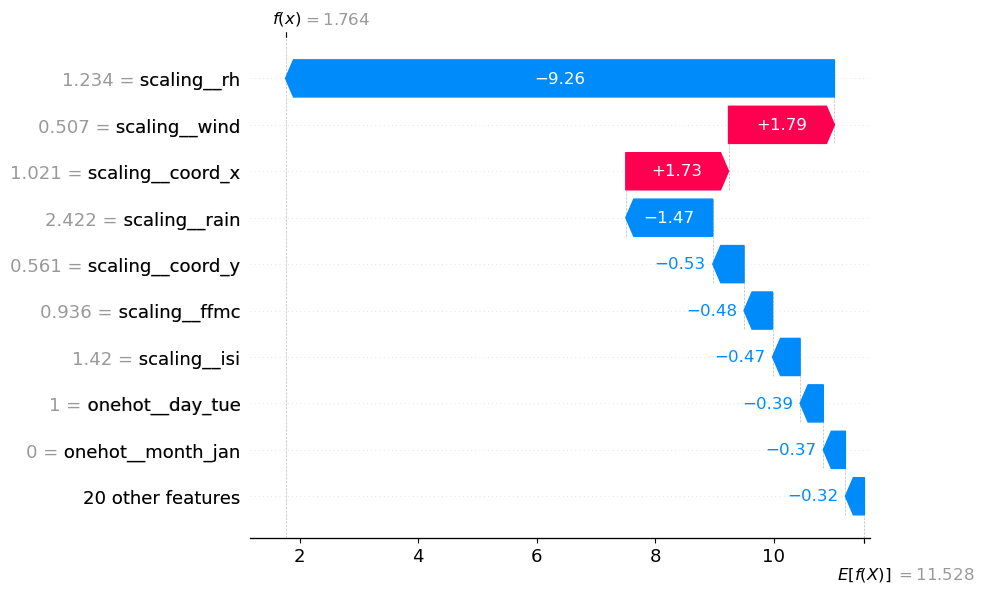

In [37]:
# Load the best model from the pickle file saved earlier
with open('best_model_A.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Access preprocessing and regressor steps
preprocessor = best_model.named_steps['preprocessing']
regressor = best_model.named_steps['regressor']

# Transform data using preprocessing
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Initialize the explainer with the background_data (X_train_transformed) to set the correct baseline
explainer = shap.KernelExplainer(regressor.predict, X_train_transformed, feature_names = preprocessor.get_feature_names_out())

# Calculate SHAP values by passing the data we want to explain (X_test_transformed) to the created explainer object
shap_values = explainer(X_test_transformed)

# Waterfall plot for single observation
shap.plots.waterfall(shap_values[1])


> **Answer (1/3) - Local Feature Importance:**
>
> For a selected observation from the test set, the most important features are `rh`, `rain`, `wind`, and `dmc`.

**Part 2: Feature Importance based on SHAP values with the training set - Global SHAP Summary**

100%|██████████| 413/413 [07:02<00:00,  1.02s/it]


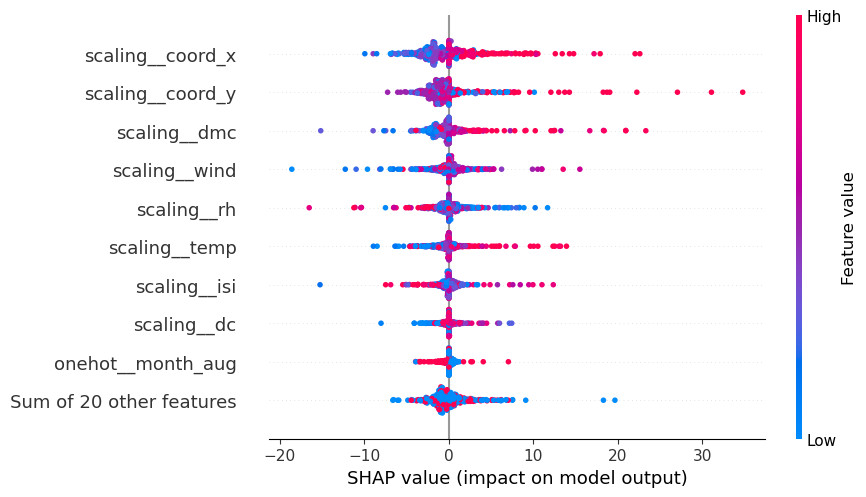

In [38]:
# calculate global SHAP values for the training set
shap_values_global = explainer(X_train_transformed)

# Use Beeswarm plot to display the contributions of each feature to all cases in the sample
shap.plots.beeswarm(shap_values_global)

In [ ]:
# Get mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values_global.values).mean(axis=0)

# Get feature names from the explainer
feature_names = shap_values_global.feature_names

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Features with mean absolute SHAP values
feature_importance_df


,feature,mean_abs_shap
0,scaling__coord_x,2.659595
1,scaling__coord_y,2.126143
3,scaling__dmc,1.745041
8,scaling__wind,1.397324
7,scaling__rh,1.375612
6,scaling__temp,1.242051
5,scaling__isi,0.907255
4,scaling__dc,0.597420
11,onehot__month_aug,0.430799
21,onehot__month_sep,0.330713


> **Answer (2/3) - Global Feature Importance:**
>
> Based on the beeswarm plot and mean absolute SHAP values, the most important features are `coord_x`, `coord_y`, and `dmc` whereas the least important features are `onehot__month_nov`, `onehot__month_jan`, and `onehot__month_may`.
>
> **Answer (3/3) - Feature Selection/Removal:**
>
> Based on the mean absolute SHAP values, I would start by removing features with a mean absolute SHAP value below 0.1. This includes the 12 least important features, from `onehot__month_jul` down to `onehot__month_nov`.
> For model performance testing, I would train a new version of the model on the feature-reduced training set and compare its performance metric (e.g., RMSE) against the original model. If performance remains stable, the new model offers the benefit of reduced complexity without a trade-off in predictive power.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.